In [1]:
# Imports here
import numpy as np
from torch import nn
from torch import optim
from torchvision import  transforms, models 
from torch.utils.data import DataLoader , Dataset
from tqdm import tqdm  # For progress bars
from collections import OrderedDict
from PIL import Image
from collections import OrderedDict
import os
import numpy as np
from collections import defaultdict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


/opt/anaconda3/envs/flowers_env/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/flowers_env/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <063DD42B-A1DA-3BBE-AD5E-03C12F7E3DBA> /opt/anaconda3/envs/flowers_env/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/flowers_env/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/flowers_env/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/flowers_env/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/flowers_env/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your e

In [2]:
#for my specific device's GPU  adjust for other hardware as needed.

import torch

if torch.backends.mps.is_available():
    print("GPU is available.")
    device = torch.device('mps')
else:
    print("GPU is not available.")
    device = torch.device('cpu')






GPU is available.


In [15]:
# create a class for our data set to use dataloders
class DriverDrowsinessDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [73]:
base_folder = './images'
drowsy_folder = os.path.join(base_folder, 'processed_drowsy_images')
non_drowsy_folder = os.path.join(base_folder, 'processed_non_drowsy_images')

video_groups = defaultdict(list)

folders = [drowsy_folder, non_drowsy_folder]
labels_dict = {}

for folder in folders:
    label = 0 if 'non_drowsy' in folder else 1
    for img_name in os.listdir(folder):
        video_id = img_name[0].lower()  # Convert starting letter to lowercase
        # in the dataset all frames belonging to the same video start  with the same letter except for z which has 3 diffrent videos  za zb zc
        if video_id == 'z' :
            video_id = img_name[0:2].lower()
        video_groups[video_id].append(os.path.join(folder, img_name))
        labels_dict[os.path.join(folder, img_name)] = label

# sepreate test set
video_group_keys = list(video_groups.keys())
np.random.shuffle(video_group_keys)
test_size = int(0.2 * len(video_group_keys))
test_groups = video_group_keys[:test_size]
train_val_groups = video_group_keys[test_size:]

# Create file paths and labels for test set
test_files = [file for group in test_groups for file in video_groups[group]]
test_labels = [labels_dict[file] for file in test_files]
## cod to spreate the data into groups and assign each fold 

k_folds = 3
folds = [[] for _ in range(k_folds)]

for idx, video_id in enumerate(train_val_groups):
    folds[idx % k_folds].extend(video_groups[video_id])


for fold_idx, fold_files in enumerate(folds, 1):
    print(f"Fold {fold_idx}")
    # print groups in each fold
    starting_letters = []
    for file in fold_files:
      base_name = os.path.basename(file).lower()
      if base_name[0]=='z':
        starting_letters.append(base_name[0:2])
      else:
        starting_letters.append(base_name[0])

    unique_starting_letters = sorted(set(starting_letters))
    print(f"Starting Letters: {unique_starting_letters}")
    print(f"Total files in fold: {len(fold_files)}")
    print("-" * 30)

Fold 1
Starting Letters: ['f', 'i', 'j', 'o', 'p', 'u', 'za', 'zc']
Total files in fold: 11898
------------------------------
Fold 2
Starting Letters: ['b', 'c', 'e', 'l', 'm', 'v', 'y', 'zb']
Total files in fold: 12835
------------------------------
Fold 3
Starting Letters: ['a', 'd', 'h', 'n', 's', 't', 'x']
Total files in fold: 11807
------------------------------


##  normalization and data augmentation

In [3]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(255),
        transforms.RandomResizedCrop(224),
         transforms.RandomRotation(15), # Random crop with resizing
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
      'test': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}



## # Experiment 1   high drop out

In [75]:
model = models.resnet50(weights=True)
print(model)



/opt/anaconda3/envs/flowers_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Experiment 1 

In [83]:


for param in model.parameters():
    param.requires_grad = False




# Unfreeze  Layer 3

for param in model.layer4.parameters():
    param.requires_grad = True




In [99]:

# Define the custom fully connected (fc) layer
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 1024, bias=True)),  
    ('relu1', nn.ReLU()),                     
    ('dropout1', nn.Dropout(0.7)), 
    ('fc2', nn.Linear(1024, 512, bias=True)),  
    ('relu2', nn.ReLU()),                     
    ('dropout2', nn.Dropout(0.5)),  # Dropout for regularization                      
    ('output', nn.Linear(512, 2, bias=True))     
]))
model.fc = fc


In [18]:

def train_model(model, trainloader, validloader, criterion, optimizer, num_epochs=20, patience=5, print_every=1, device='cpu'):
    """
    Trains and evaluates the model using softmax and cross-entropy loss.

    Args:
      model: The PyTorch model.
      trainloader: DataLoader for the training set.
      validloader: DataLoader for the validation set.
      criterion: Loss function (CrossEntropyLoss).
      optimizer: Optimizer (e.g., Adam).
      num_epochs: Number of epochs to train.
      patience: Number of epochs to wait for early stopping.
      print_every: Frequency of epochs for logging.
      device: 'cpu' or 'cuda' or mps .

    Returns:
      model: The trained model.
      avg_test_loss: The average validation loss.
      avg_valid_accuracy: The average validation accuracy.
    """
    best_val_loss = float('inf')  # Stores lowest validation loss observed
    patience_counter = 0  # Number of consecutive epochs without improvement

    # Initialize lists to collect all labels and probabilities for ROC calculation
    all_true_labels = []  # To store all true labels for the validation set
    all_predicted_probs = []  # To store all predicted probabilities for the validation set

    for e in range(num_epochs):
        # Training Phase
        train_accuracy = 0
        running_loss = 0
        model.train()

        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            log_ps = model(images)  # Forward pass (raw logits)
            loss = criterion(log_ps, labels)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy for training
            with torch.no_grad():
                ps = torch.softmax(log_ps, dim=1)  # Apply softmax for probabilities
                top_class = ps.argmax(dim=1)  # Class with highest probability
                equals = top_class == labels
                train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # Validation Phase
        if (e + 1) % print_every == 0:
            test_loss = 0
            valid_accuracy = 0

            model.eval()  # Set to evaluation mode
            with torch.no_grad():
                for inputs, labels in tqdm(validloader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    log_ps = model(inputs)  # Forward pass (raw logits)
                    batch_loss = criterion(log_ps, labels)
                    test_loss += batch_loss.item()

                    # Get the probabilities for ROC curve
                    ps = torch.softmax(log_ps, dim=1).cpu().numpy()[:, 1]  # Probability for class 1
                    all_predicted_probs.extend(ps)  # Add batch probabilities to all_predicted_probs
                    all_true_labels.extend(labels.cpu().numpy())  # Add batch true labels to all_true_labels

                    # Calculate accuracy for validation
                    ps = torch.softmax(log_ps, dim=1)
                    top_class = ps.argmax(dim=1)
                    equals = top_class == labels
                    valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # Calculate average losses and accuracies and check for early stopping
            avg_train_accuracy = train_accuracy / len(trainloader)
            avg_test_loss = test_loss / len(validloader)
            avg_valid_accuracy = valid_accuracy / len(validloader)

            if avg_test_loss < best_val_loss:
                best_val_loss = avg_test_loss
                patience_counter = 0  # Reset the counter if validation loss improves
            else:
                patience_counter += 1  # Increment if no improvement
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {e+1}")
                    break  # Stop training if no improvement for `patience` epochs

            # Print training and validation statistics
            print(f"Epoch {e+1}/{num_epochs}.. "
                  f"Train loss: {running_loss/len(trainloader):.3f}.. "
                  f"Training accuracy: {avg_train_accuracy:.3f}.. "
                  f"Validation loss: {avg_test_loss:.3f}.. "
                  f"Validation accuracy: {avg_valid_accuracy:.3f}")

            # Reset variables for the next epoch
            running_loss = 0
            train_accuracy = 0



    # Calculate and plot the ROC curve for the fold after early stopping or final epoch
    fpr, tpr, _ = roc_curve(all_true_labels, all_predicted_probs)
    roc_auc = auc(fpr, tpr)

 

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'Fold ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')  # Random chance line         
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Current Fold')
    plt.legend(loc='lower right')
    plt.show()
    return model, avg_test_loss, avg_valid_accuracy




fold  1


100%|██████████| 185/185 [01:29<00:00,  2.08it/s]


Epoch 1/40.. Train loss: 0.093.. Training accuracy: 0.970.. Validation loss: 1.225.. Validation accuracy: 0.651


100%|██████████| 185/185 [01:22<00:00,  2.25it/s]


Epoch 2/40.. Train loss: 0.076.. Training accuracy: 0.974.. Validation loss: 1.523.. Validation accuracy: 0.562


100%|██████████| 185/185 [01:22<00:00,  2.23it/s]


Epoch 3/40.. Train loss: 0.071.. Training accuracy: 0.976.. Validation loss: 1.660.. Validation accuracy: 0.590


100%|██████████| 185/185 [01:21<00:00,  2.27it/s]


Epoch 4/40.. Train loss: 0.073.. Training accuracy: 0.975.. Validation loss: 1.609.. Validation accuracy: 0.619


100%|██████████| 185/185 [01:21<00:00,  2.27it/s]


Epoch 5/40.. Train loss: 0.075.. Training accuracy: 0.975.. Validation loss: 1.535.. Validation accuracy: 0.624


100%|██████████| 185/185 [01:27<00:00,  2.11it/s]

Early stopping at epoch 6


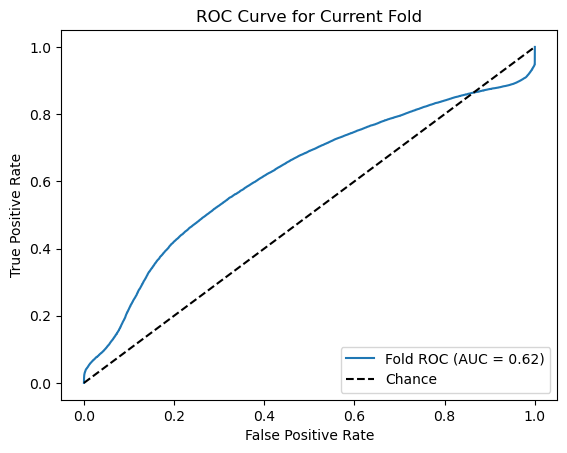

fold  2


100%|██████████| 200/200 [01:27<00:00,  2.28it/s]


Epoch 1/40.. Train loss: 0.093.. Training accuracy: 0.969.. Validation loss: 1.855.. Validation accuracy: 0.461


100%|██████████| 200/200 [01:28<00:00,  2.25it/s]


Epoch 2/40.. Train loss: 0.060.. Training accuracy: 0.981.. Validation loss: 1.568.. Validation accuracy: 0.548


100%|██████████| 200/200 [01:29<00:00,  2.24it/s]


Epoch 3/40.. Train loss: 0.056.. Training accuracy: 0.982.. Validation loss: 2.171.. Validation accuracy: 0.470


100%|██████████| 200/200 [01:30<00:00,  2.22it/s]


Epoch 4/40.. Train loss: 0.055.. Training accuracy: 0.982.. Validation loss: 2.388.. Validation accuracy: 0.409


100%|██████████| 200/200 [01:27<00:00,  2.28it/s]


Epoch 5/40.. Train loss: 0.056.. Training accuracy: 0.982.. Validation loss: 3.070.. Validation accuracy: 0.435


100%|██████████| 200/200 [01:28<00:00,  2.25it/s]


Epoch 6/40.. Train loss: 0.054.. Training accuracy: 0.983.. Validation loss: 2.195.. Validation accuracy: 0.407


100%|██████████| 200/200 [01:27<00:00,  2.28it/s]

Early stopping at epoch 7


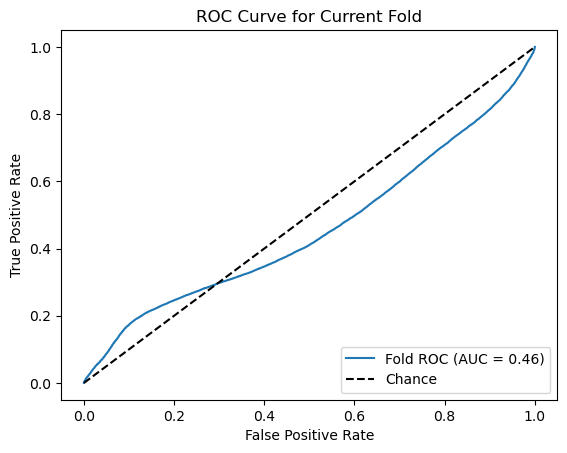

fold  3


100%|██████████| 184/184 [01:19<00:00,  2.31it/s]


Epoch 1/40.. Train loss: 0.135.. Training accuracy: 0.953.. Validation loss: 0.887.. Validation accuracy: 0.784


100%|██████████| 184/184 [01:20<00:00,  2.28it/s]


Epoch 2/40.. Train loss: 0.080.. Training accuracy: 0.973.. Validation loss: 0.546.. Validation accuracy: 0.775


100%|██████████| 184/184 [01:22<00:00,  2.24it/s]


Epoch 3/40.. Train loss: 0.068.. Training accuracy: 0.977.. Validation loss: 0.980.. Validation accuracy: 0.744


100%|██████████| 184/184 [01:21<00:00,  2.26it/s]


Epoch 4/40.. Train loss: 0.064.. Training accuracy: 0.978.. Validation loss: 0.958.. Validation accuracy: 0.754


100%|██████████| 184/184 [01:21<00:00,  2.27it/s]


Epoch 5/40.. Train loss: 0.068.. Training accuracy: 0.978.. Validation loss: 0.847.. Validation accuracy: 0.727


100%|██████████| 184/184 [01:19<00:00,  2.31it/s]


Epoch 6/40.. Train loss: 0.068.. Training accuracy: 0.976.. Validation loss: 1.072.. Validation accuracy: 0.627


100%|██████████| 184/184 [01:19<00:00,  2.31it/s]

Early stopping at epoch 7


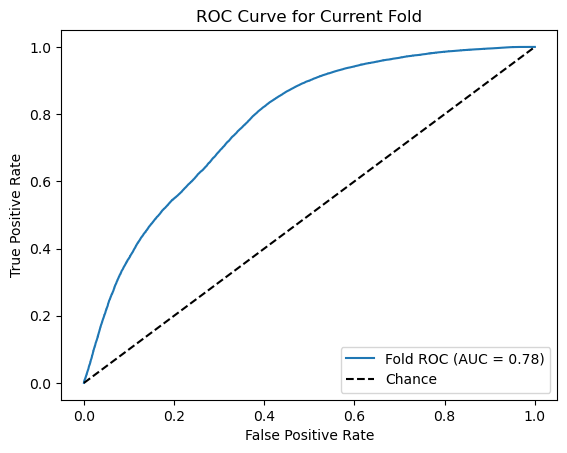

Average Validation Loss: 2.0621
Average Validation Accuracy: 0.53%


In [101]:
all_fold_val_losses = []
all_fold_val_accuracies = []
params_to_update = [param for param in model.parameters() if param.requires_grad]
# Cross-validation loop
for fold_idx in range(k_folds):
    print("fold " , fold_idx+1)
    val_files = folds[fold_idx]
    train_files = []
    for idx  in range(len(folds)):
      if idx != fold_idx:
          for file in folds[idx]:
            train_files.append(file)

    val_labels = [labels_dict[file] for file in val_files]
    train_labels = [labels_dict[file] for file in train_files]

    train_dataset = DriverDrowsinessDataset(train_files, train_labels, transform = data_transforms['train'])
    val_dataset = DriverDrowsinessDataset(val_files, val_labels, transform = data_transforms['valid'])
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last = True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True,drop_last = True)
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    optimizer = optim.Adam(params=params_to_update, lr=0.001, weight_decay=0.01)


    model, valid_loss, valid_accuracy  = train_model(model, train_loader ,val_loader, criterion, optimizer, num_epochs=40 ,device = device,print_every=1)
    all_fold_val_losses.append(valid_loss)
    all_fold_val_accuracies.append(valid_accuracy)





average_val_loss = sum(all_fold_val_losses) / k_folds
average_val_accuracy = sum(all_fold_val_accuracies) / k_folds
print(f"Average Validation Loss: {average_val_loss:.4f}")
print(f"Average Validation Accuracy: {average_val_accuracy:.2f}%")

In [102]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0

    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)  # Use CrossEntropyLoss, no need for .float()
            test_loss += loss.item() * images.size(0)  # Accumulate test loss

            # Convert outputs to predicted class
            _, predicted = torch.max(outputs, 1) # Get class with highest probability

            # Store predictions and labels for metrics
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average loss
    average_test_loss = test_loss / len(test_loader.dataset)

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(all_labels, all_predictions) * 100  # Accuracy as a percentage
    precision = precision_score(all_labels, all_predictions, average="weighted", zero_division=1)
    recall = recall_score(all_labels, all_predictions, average="weighted", zero_division=1)
    f1 = f1_score(all_labels, all_predictions, average="weighted", zero_division=1)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Print the metrics
    print(f"Test Loss: {average_test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return average_test_loss, accuracy, precision, recall, f1, conf_matrix


test_dataset = DriverDrowsinessDataset(test_files, test_labels, transform=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Run the test function
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Define criterion for softmax
criterion = torch.nn.CrossEntropyLoss()

# Run the test
test_loss, test_accuracy, precision, recall, f1, test_conf_matrix = test_model(model, test_loader, criterion, device)

100%|██████████| 82/82 [00:38<00:00,  2.15it/s]

Test Loss: 1.3479
Test Accuracy: 60.57%
Precision: 0.5956
Recall: 0.6057
F1 Score: 0.5948
Confusion Matrix:
[[ 894 1289]
 [ 777 2280]]


## Experiment 2 : Lower dropout


In [14]:
base_folder = './images'
drowsy_folder = os.path.join(base_folder, 'processed_drowsy_images')
non_drowsy_folder = os.path.join(base_folder, 'processed_non_drowsy_images')

video_groups = defaultdict(list)

folders = [drowsy_folder, non_drowsy_folder]
labels_dict = {}

for folder in folders:
    label = 0 if 'non_drowsy' in folder else 1
    for img_name in os.listdir(folder):
        video_id = img_name[0].lower()  # Convert starting letter to lowercase
        # in the dataset all frames belonging to the same video start  with the same letter except for z which has 3 diffrent videos  za zb zc
        if video_id == 'z' :
            video_id = img_name[0:2].lower()
        video_groups[video_id].append(os.path.join(folder, img_name))
        labels_dict[os.path.join(folder, img_name)] = label

# sepreate test set
video_group_keys = list(video_groups.keys())
np.random.shuffle(video_group_keys)
test_size = int(0.2 * len(video_group_keys))
test_groups = video_group_keys[:test_size]
train_val_groups = video_group_keys[test_size:]

# Create file paths and labels for test set
test_files = [file for group in test_groups for file in video_groups[group]]
test_labels = [labels_dict[file] for file in test_files]
## cod to spreate the data into groups and assign each fold 

k_folds = 3
folds = [[] for _ in range(k_folds)]

for idx, video_id in enumerate(train_val_groups):
    folds[idx % k_folds].extend(video_groups[video_id])


for fold_idx, fold_files in enumerate(folds, 1):
    print(f"Fold {fold_idx}")
    # print groups in each fold
    starting_letters = []
    for file in fold_files:
      base_name = os.path.basename(file).lower()
      if base_name[0]=='z':
        starting_letters.append(base_name[0:2])
      else:
        starting_letters.append(base_name[0])

    unique_starting_letters = sorted(set(starting_letters))
    print(f"Starting Letters: {unique_starting_letters}")

Fold 1
Starting Letters: ['a', 'b', 'e', 'g', 'l', 's', 'u', 'zb']
Fold 2
Starting Letters: ['c', 'd', 'h', 'i', 'm', 't', 'v', 'x']
Fold 3
Starting Letters: ['f', 'j', 'k', 'o', 'q', 'w', 'za']


In [9]:

# Load the pretrained ResNet-50 model
model2 = models.resnet50(pretrained=True)



# Freeze all layers by sett
for param in model2.parameters():
    param.requires_grad = False



In [28]:

# Define the custom fully connected (fc) layer
fc2 = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 1024, bias=True)),  
    ('relu1', nn.ReLU()),                     
    ('dropout1', nn.Dropout(0.5)), 
    ('fc2', nn.Linear(1024, 512, bias=True)),  
    ('relu2', nn.ReLU()),                     
    ('dropout2', nn.Dropout(0.4)),  # Dropout for regularization                      
    ('output', nn.Linear(512, 2, bias=True))     
]))
model2.fc = fc2



fold  1


100%|██████████| 183/183 [01:18<00:00,  2.34it/s]


Epoch 1/40.. Train loss: 0.595.. Training accuracy: 0.666.. Validation loss: 0.782.. Validation accuracy: 0.401


100%|██████████| 183/183 [01:18<00:00,  2.33it/s]


Epoch 2/40.. Train loss: 0.545.. Training accuracy: 0.709.. Validation loss: 0.899.. Validation accuracy: 0.408


100%|██████████| 183/183 [01:17<00:00,  2.38it/s]


Epoch 3/40.. Train loss: 0.530.. Training accuracy: 0.720.. Validation loss: 0.914.. Validation accuracy: 0.462


100%|██████████| 183/183 [01:18<00:00,  2.34it/s]


Epoch 4/40.. Train loss: 0.517.. Training accuracy: 0.728.. Validation loss: 0.925.. Validation accuracy: 0.428


100%|██████████| 183/183 [01:18<00:00,  2.34it/s]


Epoch 5/40.. Train loss: 0.493.. Training accuracy: 0.740.. Validation loss: 0.827.. Validation accuracy: 0.468


100%|██████████| 183/183 [01:18<00:00,  2.34it/s]

Early stopping at epoch 6


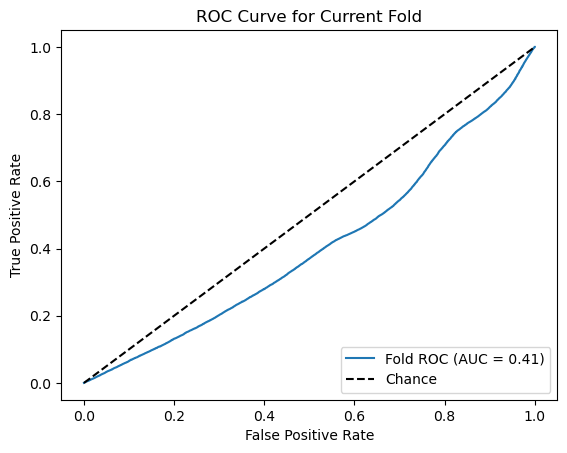

fold  2


100%|██████████| 185/185 [01:19<00:00,  2.32it/s]


Epoch 1/40.. Train loss: 0.580.. Training accuracy: 0.684.. Validation loss: 0.681.. Validation accuracy: 0.589


100%|██████████| 185/185 [01:19<00:00,  2.34it/s]


Epoch 2/40.. Train loss: 0.519.. Training accuracy: 0.738.. Validation loss: 0.803.. Validation accuracy: 0.488


100%|██████████| 185/185 [01:19<00:00,  2.32it/s]


Epoch 3/40.. Train loss: 0.493.. Training accuracy: 0.752.. Validation loss: 0.849.. Validation accuracy: 0.497


100%|██████████| 185/185 [01:18<00:00,  2.35it/s]


Epoch 4/40.. Train loss: 0.494.. Training accuracy: 0.744.. Validation loss: 0.785.. Validation accuracy: 0.543


100%|██████████| 185/185 [01:18<00:00,  2.35it/s]


Epoch 5/40.. Train loss: 0.508.. Training accuracy: 0.738.. Validation loss: 1.070.. Validation accuracy: 0.455


100%|██████████| 185/185 [01:19<00:00,  2.33it/s]

Early stopping at epoch 6


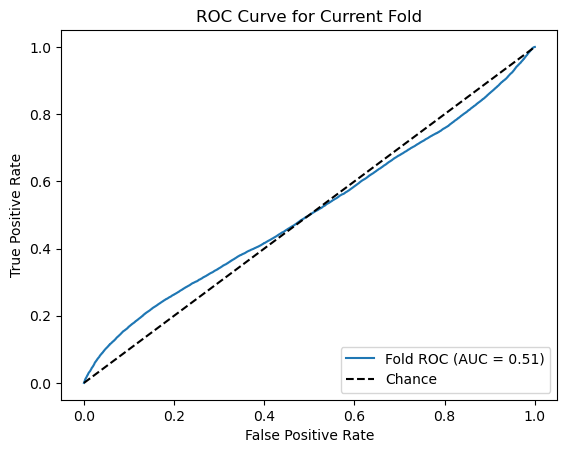

fold  3


100%|██████████| 139/139 [01:11<00:00,  1.94it/s]


Epoch 1/40.. Train loss: 0.551.. Training accuracy: 0.706.. Validation loss: 0.582.. Validation accuracy: 0.684


100%|██████████| 139/139 [01:19<00:00,  1.74it/s]


Epoch 2/40.. Train loss: 0.502.. Training accuracy: 0.741.. Validation loss: 0.651.. Validation accuracy: 0.605


100%|██████████| 139/139 [01:22<00:00,  1.68it/s]


Epoch 3/40.. Train loss: 0.476.. Training accuracy: 0.757.. Validation loss: 0.689.. Validation accuracy: 0.532


100%|██████████| 139/139 [01:21<00:00,  1.70it/s]


Epoch 4/40.. Train loss: 0.466.. Training accuracy: 0.759.. Validation loss: 0.769.. Validation accuracy: 0.503


100%|██████████| 139/139 [01:17<00:00,  1.79it/s]


Epoch 5/40.. Train loss: 0.477.. Training accuracy: 0.750.. Validation loss: 0.722.. Validation accuracy: 0.518


100%|██████████| 139/139 [01:17<00:00,  1.80it/s]

Early stopping at epoch 6


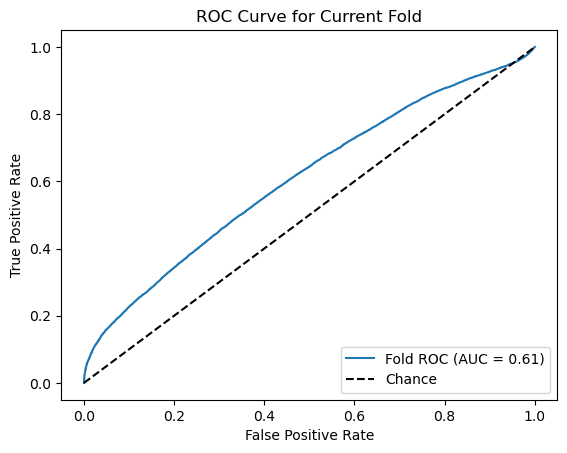

Average Validation Loss: 0.8591
Average Validation Accuracy: 0.49%


In [30]:
all_fold_val_losses = []
all_fold_val_accuracies = []
params_to_update = [param for param in model2.parameters() if param.requires_grad]
# Cross-validation loop
for fold_idx in range(k_folds):
    print("fold " , fold_idx+1)
    val_files = folds[fold_idx]
    train_files = []
    for idx  in range(len(folds)):
      if idx != fold_idx:
          for file in folds[idx]:
            train_files.append(file)

    val_labels = [labels_dict[file] for file in val_files]
    train_labels = [labels_dict[file] for file in train_files]

    train_dataset = DriverDrowsinessDataset(train_files, train_labels, transform = data_transforms['train'])
    val_dataset = DriverDrowsinessDataset(val_files, val_labels, transform = data_transforms['valid'])
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last = True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True,drop_last = True)
    criterion = nn.CrossEntropyLoss()
    model2.to(device)

    optimizer = optim.Adam(params=params_to_update, lr=0.001, weight_decay=0.01)


    model, valid_loss, valid_accuracy  = train_model(model2, train_loader ,val_loader, criterion, optimizer, num_epochs=40 ,device = device,print_every=1)
    all_fold_val_losses.append(valid_loss)
    all_fold_val_accuracies.append(valid_accuracy)





average_val_loss = sum(all_fold_val_losses) / k_folds
average_val_accuracy = sum(all_fold_val_accuracies) / k_folds
print(f"Average Validation Loss: {average_val_loss:.4f}")
print(f"Average Validation Accuracy: {average_val_accuracy:.2f}%")

In [ ]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0

    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)  # Use CrossEntropyLoss, no need for .float()
            test_loss += loss.item() * images.size(0)  # Accumulate test loss

            # Convert outputs to predicted class
            _, predicted = torch.max(outputs, 1) # Get class with highest probability

            # Store predictions and labels for metrics
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average loss
    average_test_loss = test_loss / len(test_loader.dataset)

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(all_labels, all_predictions) * 100  # Accuracy as a percentage
    precision = precision_score(all_labels, all_predictions, average="weighted", zero_division=1)
    recall = recall_score(all_labels, all_predictions, average="weighted", zero_division=1)
    f1 = f1_score(all_labels, all_predictions, average="weighted", zero_division=1)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Print the metrics
    print(f"Test Loss: {average_test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return average_test_loss, accuracy, precision, recall, f1, conf_matrix


test_dataset = DriverDrowsinessDataset(test_files, test_labels, transform=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Run the test function
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Define criterion for softmax
criterion = torch.nn.CrossEntropyLoss()

# Run the test
test_loss, test_accuracy, precision, recall, f1, test_conf_matrix = test_model(model2, test_loader, criterion, device)

100%|██████████| 145/145 [01:26<00:00,  1.68it/s]

Test Loss: 1.0758
Test Accuracy: 47.34%
Precision: 0.4766
Recall: 0.4734
F1 Score: 0.4673
Confusion Matrix:
[[2609 1847]
 [3017 1764]]


## Baseline model : simple cnn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a simple CNN with a classifier for Drowsy and Non-Drowsy classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        
        # Fully connected layer: input size depends on input image dimensions (224x224 here)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Hidden layer
        self.fc2 = nn.Linear(128, 2)  # Output layer for 2 classes (Drowsy and Non-Drowsy)

    def forward(self, x):
        # Convolutional layer 1 + ReLU + Pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Convolutional layer 2 + ReLU + Pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output
        x = torch.flatten(x, 1)
        # Fully connected layers
        x = F.relu(self.fc1(x))  # Add ReLU for hidden layer
        x = self.fc2(x)  # Output layer
        return x

# Initialize the model
model0 = SimpleCNN()

print(model)


fold  1


100%|██████████| 183/183 [00:57<00:00,  3.17it/s]


Epoch 1/40.. Train loss: 0.250.. Training accuracy: 0.892.. Validation loss: 1.113.. Validation accuracy: 0.474


100%|██████████| 183/183 [00:50<00:00,  3.62it/s]


Epoch 2/40.. Train loss: 0.221.. Training accuracy: 0.907.. Validation loss: 1.406.. Validation accuracy: 0.553


100%|██████████| 183/183 [00:51<00:00,  3.57it/s]


Epoch 3/40.. Train loss: 0.199.. Training accuracy: 0.918.. Validation loss: 1.396.. Validation accuracy: 0.465


100%|██████████| 183/183 [00:50<00:00,  3.59it/s]


Epoch 4/40.. Train loss: 0.201.. Training accuracy: 0.917.. Validation loss: 1.595.. Validation accuracy: 0.499


100%|██████████| 183/183 [00:51<00:00,  3.55it/s]


Epoch 5/40.. Train loss: 0.188.. Training accuracy: 0.925.. Validation loss: 1.899.. Validation accuracy: 0.457


100%|██████████| 183/183 [00:56<00:00,  3.22it/s]

Early stopping at epoch 6


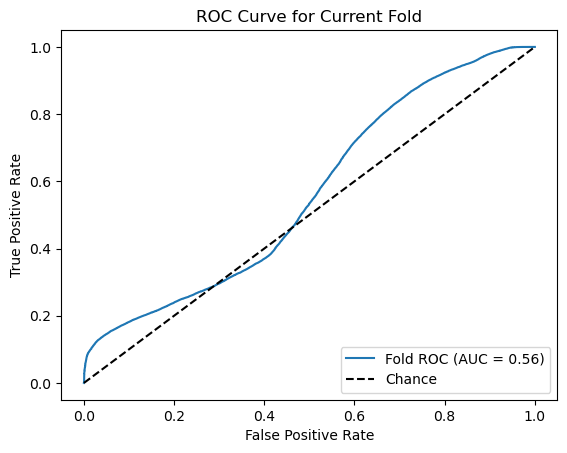

fold  2


100%|██████████| 185/185 [01:09<00:00,  2.67it/s]


Epoch 1/40.. Train loss: 0.337.. Training accuracy: 0.856.. Validation loss: 0.272.. Validation accuracy: 0.891


100%|██████████| 185/185 [00:57<00:00,  3.20it/s]


Epoch 2/40.. Train loss: 0.247.. Training accuracy: 0.898.. Validation loss: 0.355.. Validation accuracy: 0.858


100%|██████████| 185/185 [01:00<00:00,  3.06it/s]


Epoch 3/40.. Train loss: 0.230.. Training accuracy: 0.910.. Validation loss: 0.321.. Validation accuracy: 0.829


100%|██████████| 185/185 [00:57<00:00,  3.22it/s]


Epoch 4/40.. Train loss: 0.214.. Training accuracy: 0.916.. Validation loss: 0.515.. Validation accuracy: 0.763


100%|██████████| 185/185 [01:11<00:00,  2.59it/s]


Epoch 5/40.. Train loss: 0.226.. Training accuracy: 0.909.. Validation loss: 0.564.. Validation accuracy: 0.774


100%|██████████| 185/185 [01:01<00:00,  2.99it/s]

Early stopping at epoch 6


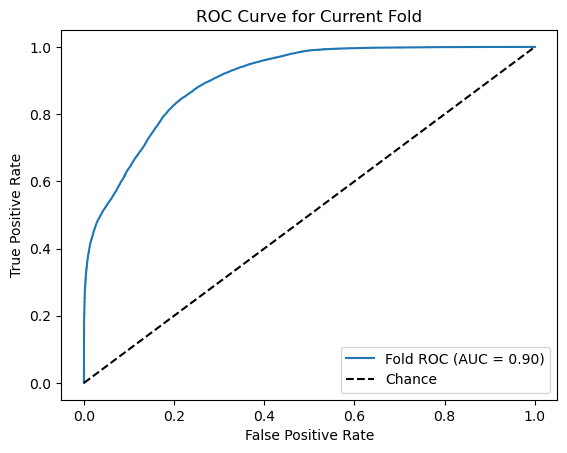

fold  3


100%|██████████| 139/139 [00:45<00:00,  3.06it/s]


Epoch 1/40.. Train loss: 0.238.. Training accuracy: 0.907.. Validation loss: 3.228.. Validation accuracy: 0.637


100%|██████████| 139/139 [00:58<00:00,  2.38it/s]


Epoch 2/40.. Train loss: 0.198.. Training accuracy: 0.919.. Validation loss: 5.409.. Validation accuracy: 0.472


100%|██████████| 139/139 [00:46<00:00,  2.97it/s]


Epoch 3/40.. Train loss: 0.193.. Training accuracy: 0.922.. Validation loss: 5.537.. Validation accuracy: 0.420


100%|██████████| 139/139 [00:42<00:00,  3.24it/s]


Epoch 4/40.. Train loss: 0.182.. Training accuracy: 0.926.. Validation loss: 5.536.. Validation accuracy: 0.565


100%|██████████| 139/139 [00:44<00:00,  3.13it/s]


Epoch 5/40.. Train loss: 0.181.. Training accuracy: 0.930.. Validation loss: 5.691.. Validation accuracy: 0.531


100%|██████████| 139/139 [00:41<00:00,  3.34it/s]

Early stopping at epoch 6


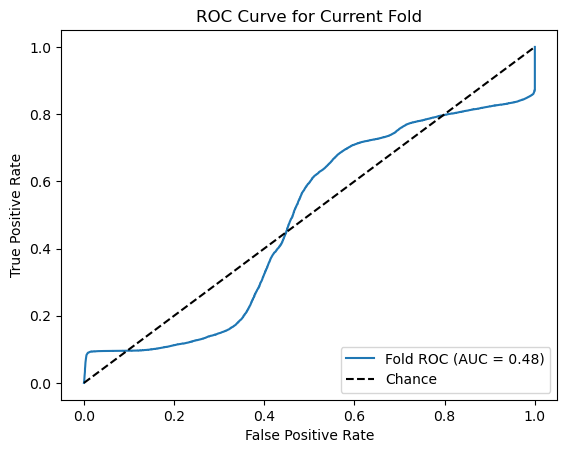

Average Validation Loss: 2.1991
Average Validation Accuracy: 0.56%


In [39]:
all_fold_val_losses = []
all_fold_val_accuracies = []
params_to_update = [param for param in model0.parameters() if param.requires_grad]
# Cross-validation loop
for fold_idx in range(k_folds):
    print("fold " , fold_idx+1)
    val_files = folds[fold_idx]
    train_files = []
    for idx  in range(len(folds)):
      if idx != fold_idx:
          for file in folds[idx]:
            train_files.append(file)

    val_labels = [labels_dict[file] for file in val_files]
    train_labels = [labels_dict[file] for file in train_files]

    train_dataset = DriverDrowsinessDataset(train_files, train_labels, transform = data_transforms['train'])
    val_dataset = DriverDrowsinessDataset(val_files, val_labels, transform = data_transforms['valid'])
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last = True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True,drop_last = True)
    criterion = nn.CrossEntropyLoss()
    model0.to(device)

    optimizer = optim.Adam(params=params_to_update, lr=0.001, weight_decay=0.01)


    model, valid_loss, valid_accuracy  = train_model(model0, train_loader ,val_loader, criterion, optimizer, num_epochs=40 ,device = device,print_every=1)
    all_fold_val_losses.append(valid_loss)
    all_fold_val_accuracies.append(valid_accuracy)





average_val_loss = sum(all_fold_val_losses) / k_folds
average_val_accuracy = sum(all_fold_val_accuracies) / k_folds
print(f"Average Validation Loss: {average_val_loss:.4f}")
print(f"Average Validation Accuracy: {average_val_accuracy:.2f}%")

In [40]:
test_loss, test_accuracy, precision, recall, f1, test_conf_matrix = test_model(model0, test_loader, criterion, device)

100%|██████████| 145/145 [00:45<00:00,  3.19it/s]

Test Loss: 2.8870
Test Accuracy: 50.21%
Precision: 0.4966
Recall: 0.5021
F1 Score: 0.4884
Confusion Matrix:
[[1481 2975]
 [1624 3157]]
